<a href="https://colab.research.google.com/github/engomarwasfy/DIP/blob/main/Image_Mosiacs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1 Image Mosaics
 In this part of the assignment, you will implement an image stitcher that uses image warping
and homographies to automatically create an image mosaic. We will focus on the case where we
have two input images that should form the mosaic, where we warp one image into the plane
of the second image and display the combined views. This problem will give some practice
manipulating homogeneous coordinates, computing homography matrices, and performing image warps. For simplicity, we will specify corresponding pairs of points manually using mouse
clicks.

Imports

In [ ]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import cv2 as cv
from numpy.linalg import inv
from scipy.interpolate import RectBivariateSpline as interpolate
import math
import random
from PIL import Image
fig=None

Plot functions

In [ ]:
def plot_image(image,color,title):
  plt.grid("false")
  plt.title(title)
  if(color=='colored'):
    plt.imshow(image)
  elif(color=="gray"):
    plt.imshow(image,cmap='gray',interpolation="bicubic")
def BGR2RGB(image):
  return cv.cvtColor(image,cv.COLOR_BGR2RGB)
def read_image(name):
  image = cv.imread(name)
  RGB_image=BGR2RGB(image)
  plot_image(RGB_image,"colored","Original RGB Image")
  return image

# 1.1 Getting Correspondences
Plot the input images and collect mouse click positions. The results will be sensitive to the
accuracy of the corresponding points, when providing clicks, choose distinctive points in the
image that appear in both views.





---

Using TkAgg interactive backend terminal to catch mappings

---



In [ ]:
def get_correspondance_manually(image1,image2,number_of_points):
        matplotlib.use('TkAgg')
    # Display images, select matching points
        fig = plt.figure()
        figA = fig.add_subplot(1,2,1)
        figB = fig.add_subplot(1,2,2)
    # Display the image
    # lower use to flip the image
        figA.imshow(image1)#,origin='lower')
        figB.imshow(image2)#,origin='lower')
        plt.axis('image')
        # n = number of points to read
        p1 = np.zeros([(number_of_points//2),2])
        p2 = np.zeros([number_of_points//2,2])
        pts = plt.ginput(n=number_of_points, timeout=0)
        p1_itr = 0
        p2_itr = 0
        for i in range(0, number_of_points):
            if (i % 2 == 0):
                p1[p1_itr] = pts[i]
                print("p1 of index ", p1_itr, " is ", pts[i])
                p1_itr += 1
            else:
                p2[p2_itr] = pts[i]
                print("p2 of index ", p2_itr, " is ", pts[i])
                p2_itr += 1
        plt.close(fig)
        %matplotlib inline
        return p1, p2
def get_coordinates(kps,index):
  point = kps[index]
  return point[0] , point[1]

#1.2 Compute the Homography Parameters 
---
Write a function that takes a set of corresponding image points and computes the associated
3×3 homography matrix H. This matrix transforms any point p in one view to its corresponding
homogeneous coordinates in the second view, p’, such that p’ = Hp. Note that p and p’ are both
3D points in homogeneous coordinates. The function should take a list of n >= 4 pairs of corresponding points from the two views, where each point is specified with its 2D image coordinates.
We can set up a solution using a system of linear equations Ax = b, where the 8 unknowns
of H are stacked into an 8-vector x , the 2n-vector b contains image points from one view, and
the 2n × 8 matrix A is filled appropriately so that the full system gives us λp = Hp. There are only 8 unknowns in H because we set H3;3 = 1. Solve for the unknown homography matrix parameters.

---
Verify that the homography matrix your function computes is correct by mapping the clicked
image points from one view to the other, and displaying them on top of each respective image.
Be sure to handle homogenous and non-homogenous coordinates correctly

In [ ]:
def get_sub_a_matrix(x,y,x_,y_):
  matrix=np.zeros((2,8))
  matrix[0]=np.array([x, y,1,0,0,0, -x*x_, -y*x_])
  matrix[1]=np.array([0,0,0,x, y,1, -x*y_, -y*y_])
  return matrix
def get_homography_matrix(kps_a,kps_b):
  n=len(kps_a)
  #build b 
  b = np.zeros(((2*n),1))
  for i in range(n):
    b[2*i], b[2*i +1]=get_coordinates(kps_b,i)
  # build a
  a = np.zeros(((2*n),8))
  for i in range(n):
    x,y=get_coordinates(kps_a,i)
    x_,y_=get_coordinates(kps_b,i)
    sub_a_matrix=get_sub_a_matrix(x,y,x_,y_)
    a[2*i] = sub_a_matrix[0]
    a[2*i + 1] = sub_a_matrix[1]		
  # Solve equations to compute H
  H=np.linalg.lstsq(a, b)[0]
  H=np.append(H,1)
  H=np.reshape(H,(3,3))
  return H
def verify_H(px,py,H):
  a=np.ones((3,1))
  a[0,0]=px
  a[1,0]=py
  b=np.dot(H,a)
  b=b/b[2,0]
  print(b)
  return b

Transform and Inverse Transform

In [ ]:
def transform(point,H):
  result = np.dot(H, point)
  w=result[2]
  result[0] = result[0]/w
  result[1] = result[1]/w
  result[2] = 1
  return result
def inv_transform(point,H):
  result = np.dot(np.linalg.inv(H), point)
  w=result[2]
  result[0] = result[0]/w
  result[1] = result[1]/w
  result[2] = 1
  return result

# 1.3 Warping Between Image Planes
Write a function that can take the recovered homography matrix and an image, and return a
new image that is the warp of the input image using H . Since the transformed coordinates
will typically be sub-pixel values, you will need to sample the pixel values from nearby pixels.
For color images, warp each RGB channel separately and then stack together to form the output.
To avoid holes in the output, use an inverse warp. Warp the points from the source image
into the reference frame of the destination, and compute the bounding box in that new reference
frame. Then sample all points in that destination bounding box from the proper coordinates
in the source image (linear interpolation). Note that transforming all the points will generate
an image of a different shape/dimensions than the original input.



image size after wrap effect


In [ ]:
def wraped_image_size(image_a , H):
  height = image_a.shape[0]
  width = image_a.shape[1]
  
  boundaries = np.array([[0,0],[height-1, 0],[0, width-1],[height-1, width-1]])
  i_s =np.zeros(4,dtype=int)
  j_s =np.zeros(4,dtype=int)
  
  for k in range(0,4):
    i = boundaries[k][0]
    j = boundaries[k][1]
    mapped = transform(np.array([[j],[i],[1]]), H)
    j_s[k] = int(mapped[0][0])
    i_s[k] = int(mapped[1][0])
          
  min_mapped_i=np.min(i_s)
  min_mapped_j=np.min(j_s)
  max_mapped_i=np.max(i_s)
  max_mapped_j=np.max(j_s)
   
  new_height = (max_mapped_i-min_mapped_i+1)
  new_width = (max_mapped_j-min_mapped_j+1)
  
  height_shift =-min_mapped_i
  width_shift =-min_mapped_j
  
  return (new_height,new_width,height_shift,width_shift)

wrap image1 and return new Wraped image

In [ ]:
def wrap(image_a , H):
  height = image_a.shape[0]
  width = image_a.shape[1]

  (wraped_image_height,wraped_image_width,height_shift,width_shift)=wraped_image_size(image_a , H)
  wraped_image = np.zeros((wraped_image_height,wraped_image_width,3), dtype=np.uint8);
  
  for i in range(0,image_a.shape[0]):
    for j in range(0,image_a.shape[1]):
      mapped = transform(np.array([[j],[i],[1]]), H)
      mapped_j = int(mapped[0][0])
      mapped_i = int(mapped[1][0])
      wraped_image[mapped_i+height_shift][mapped_j+width_shift] = image_a[i][j]
      
  return (wraped_image,height_shift,width_shift)

Remove holes by interpolation of inverse H returning to original photo

In [ ]:
def remove_holes(wraped_image,H,image_a,height_shift,width_shift):
  height = image_a.shape[0]
  width = image_a.shape[1]
  
  wraped_image_height=wraped_image.shape[0]
  wraped_image_width=wraped_image.shape[1]
  
  for i in range(0, wraped_image_height):
    for j in range(0, wraped_image_width):
      if int(wraped_image[i][j][0]) == 0 and int(wraped_image[i][j][1]) == 0 and int(wraped_image[i][j][2]) == 0:
        inv_mapped = inv_transform(np.array([[(j - width_shift)], [(i-height_shift)],[1]]),H)
        inv_mapped_j = inv_mapped[0][0]
        inv_mapped_i = inv_mapped[1][0]
        if inv_mapped_i <= height-1 and  inv_mapped_i >= 0 and inv_mapped_j <= width-1 and inv_mapped_j >= 0:
          index_i = int(inv_mapped_i);
          index_j = int(inv_mapped_j);
          a = inv_mapped_i - index_i;
          b = inv_mapped_j - index_j;
          wraped_image[i][j] = (1-a)*(1-b)*image_a[index_i][index_j]+ a*(1-b)*image_a[index_i+1][index_j]+ a*b*image_a[index_i+1][index_j+1]+ (1-a)*b*image_a[index_i][index_j+1]  
  return wraped_image

#1.4 Create the output mosaic
 Once we have the source image warped into the destination images frame of reference, we can
create a merged image showing the mosaic. Create a new image large enough to hold both (registered) views; overlay one view onto the other, simply leaving it black wherever no data is
available. Do not worry about artifacts that result at the boundaries.


---

Create Mosaic between wraped image and second image

In [ ]:
def create_mosaic(wraped_image,image_b,height_shift,width_shift):
  wraped_image_height=wraped_image.shape[0]
  wraped_image_width=wraped_image.shape[1]

  image_b_height = image_b.shape[0]
  image_b_width = image_b.shape[1]
    #get dimensions for the new image
  mosaic_height = max(wraped_image_height, image_b_height+height_shift)
  mosaic_width= max(wraped_image_width, image_b_width+width_shift)  
  mosaic = np.zeros((mosaic_height, mosaic_width, 3), dtype=np.uint8)
  
  for i in range(0,image_b_height):
    for j in range(0, image_b_width):
      mosaic[i+height_shift][j+width_shift] = image_b[i][j]
  for i in range(0,wraped_image_height):
    for j in range(0, wraped_image_width):
      if not(int(wraped_image[i][j][0]) == 0 and int(wraped_image[i][j][1]) == 0 and int(wraped_image[i][j][2]) == 0):
        mosaic[i][j] = wraped_image[i][j]
        
  return mosaic

Automatic Feature Matching using CV libraries 
To compare the results of manual and automated choices

In [ ]:
def detect_describe(image):
  orb = cv.ORB_create(nfeatures=1000)
  copy_img=image
  key_pts, descriptors = orb.detectAndCompute(copy_img, None) 
  return key_pts, descriptors
def match(image_a,image_b):
  corres_List = []
  key_pts_a, descriptors_a=detect_describe(image_a)
  key_pts_b, descriptors_b=detect_describe(image_b)
#   copy_a=image_a
#   copy_b=image_b
#   draw_keypoints(copy_a,key_pts_a)
#   draw_keypoints(copy_b,key_pts_b)
  bf = cv.BFMatcher(cv.NORM_HAMMING, crossCheck=True)
  matches = bf.match(descriptors_a, descriptors_b)
  matches = sorted(matches, key = lambda x: x.distance)
  img_matches = cv.drawMatches(image_a, key_pts_a, image_b, key_pts_b, matches[:4], image_b, flags=2)
  plot_image(BGR2RGB(img_matches),"colored","Matching")
  num_of_req_matches=10
  # Initialize arrays
  kps_a = np.zeros((0,2))
  kps_b = np.zeros((0,2))
  matches=matches[:num_of_req_matches]
  for match in matches:
    # Get the matching keypoints for each of the images
    img_a_idx = match.queryIdx
    img_b_idx = match.trainIdx
    # Get the coordinates
    (x1,y1) = key_pts_a[img_a_idx].pt
    (x2,y2) = key_pts_b[img_b_idx].pt
    # Append to each list
    #############################################################
    corres_List.append([x1, y1, x2, y2]) 
    #############################################################
    kps_a=np.vstack((kps_a,(x1, y1)))
    kps_b=np.vstack((kps_b,(x2, y2))) 
    
  correspoints = np.matrix(corres_List)
 
  return kps_a , kps_b ,correspoints ,matches

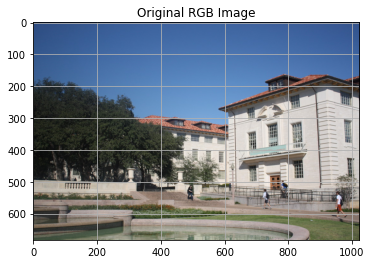

In [ ]:
image1 = read_image('C:\\Users\\wasfy\\Downloads\\CVDS\\image1.jpg')

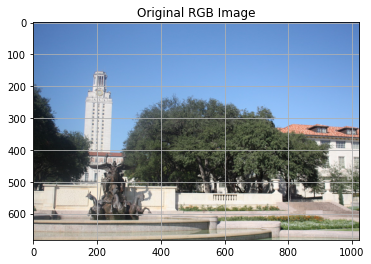

In [ ]:
image2 = read_image('C:\\Users\\wasfy\\Downloads\\CVDS\\image2.jpg')

In [ ]:
N=10
(p1,p2)=get_correspondance_manually(image1,image2,2*N)

p1 of index  0  is  (102.17567184621919, 498.81729561233647)
p2 of index  0  is  (565.1302649600912, 539.2491663911586)
p1 of index  1  is  (108.55965144287535, 566.9130779766684)
p2 of index  1  is  (575.770230954518, 611.6009351532612)
p1 of index  2  is  (312.84699853587114, 588.1930099655222)
p2 of index  2  is  (771.5456052519721, 626.4968875454588)
p1 of index  3  is  (308.59101213810044, 454.1294384357436)
p2 of index  3  is  (760.9056392575453, 483.92134322013885)
p1 of index  4  is  (434.14261087233746, 309.4259009115383)
p2 of index  4  is  (877.9452651962406, 332.8338260992774)
p1 of index  5  is  (517.1343456288669, 320.0658669059652)
p2 of index  5  is  (969.4489727483119, 337.0898124970481)
p1 of index  6  is  (506.4943796344401, 356.24175128701654)
p2 of index  6  is  (960.9369999527703, 377.52168327587026)
p1 of index  7  is  (549.0542436121475, 358.36974448590195)
p2 of index  7  is  (1009.880843527134, 375.39369007698485)
p1 of index  8  is  (463.9345156567327, 469.02

In [ ]:
H=get_homography_matrix(p1,p2)
H

C:\Users\wasfy\.conda\envs\jupyterlab\lib\site-packages\ipykernel_launcher.py:21: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


array([[ 7.09131388e-01, -5.12377991e-02,  4.69229446e+02],
       [-1.45517376e-01,  8.24893844e-01,  9.63844318e+01],
       [-2.16862050e-04, -1.32001185e-04,  1.00000000e+00]])

As we see the error between original P2 and computed P2 = H*P1 is due to multiple facts



**1-**choosen points are not exactly perfectly true,Human error in choosing the right pixel place exactly



**2-**Another error is that the surface is not perfectly planner
some objects induce diffrent transformation between two photos and the only way to descripe such transformation is impossible using linear transformation this needs non linear transformation based on semantics of photo to detect regions of constant transformation

In [ ]:
N=10
pNew=p1
for x in range(N) :
  pNew[x] =(verify_H(p1[x,0],p1[x,1],H))[0][:1]
print('++++++++++++++++++++++++++error+++++++++++++++++++++++++')
print(pNew-p2)

[[565.93041272]
 [540.55785524]
 [  1.        ]]
[[573.59268694]
 [608.04728105]
 [  1.        ]]
[[773.47122238]
 [627.32390853]
 [  1.        ]]
[[761.38762031]
 [487.99873999]
 [  1.        ]]
[[880.03896094]
 [333.46883126]
 [  1.        ]]
[[969.18423219]
 [337.21780455]
 [  1.        ]]
[[960.8737123]
 [375.4343663]
 [  1.       ]]
[[1.00790910e+03]
 [3.74394024e+02]
 [1.00000000e+00]]
[[924.42770421]
 [496.45471997]
 [  1.        ]]
[[1.00087643e+03]
 [5.32763182e+02]
 [1.00000000e+00]]
++++++++++++++++++++++++++error+++++++++++++++++++++++++
[[ 8.00147755e-01  2.66812463e+01]
 [-2.17754401e+00 -3.80082482e+01]
 [ 1.92561713e+00  1.46974335e+02]
 [ 4.81981055e-01  2.77466277e+02]
 [ 2.09369574e+00  5.47205135e+02]
 [-2.64740560e-01  6.32094420e+02]
 [-6.32876572e-02  5.83352029e+02]
 [-1.97174640e+00  6.32515407e+02]
 [-2.46140456e+00  4.25610409e+02]
 [ 1.63555371e+00  4.70139238e+02]]


67
-469


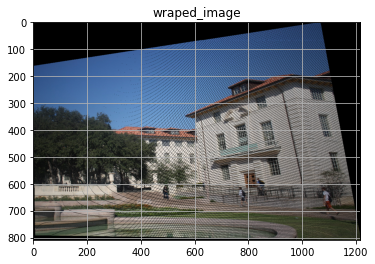

In [ ]:
(wraped_image,height_shift,width_shift) = wrap(image1,H)
print(height_shift)
print(width_shift)
plot_image(BGR2RGB(wraped_image),'colored','wraped_image')

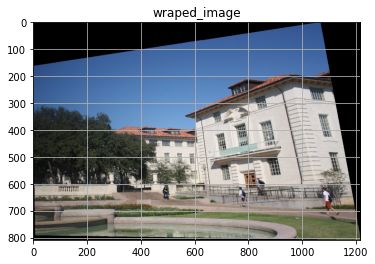

In [ ]:
wraped_image=remove_holes(wraped_image,H,image1,height_shift,width_shift)
plot_image(BGR2RGB(wraped_image),'colored','wraped_image')

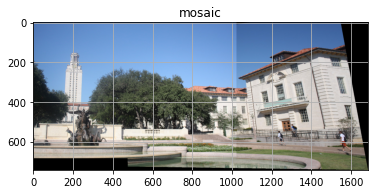

In [ ]:
mosaic=create_mosaic(image2,wraped_image,-height_shift,-width_shift)
plot_image(BGR2RGB(mosaic),'colored','mosaic')

Automatic matcher and ransac

In [ ]:
kp_a,kp_b,correspoints,matches = match(image1,image2)
h,mask= cv.findHomography(kp_a, kp_b, cv.RANSAC,5)
print (h)
print(mask)

96
-435


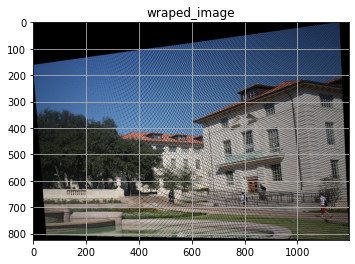

In [ ]:
(Autowraped_image,height_shift,width_shift) = wrap(image1,h)
print(height_shift)
print(width_shift)
plot_image(BGR2RGB(Autowraped_image),'colored','wraped_image')

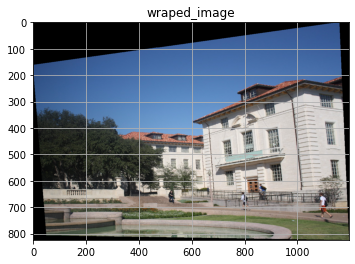

In [ ]:
Autowraped_image=remove_holes(Autowraped_image,h,image1,height_shift,width_shift)
plot_image(BGR2RGB(Autowraped_image),'colored','wraped_image')

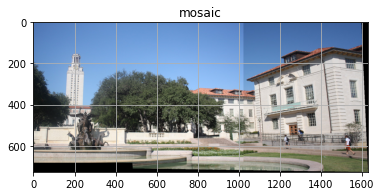

In [ ]:
Automosaic=create_mosaic(image2,Autowraped_image,-height_shift,-width_shift)
plot_image(BGR2RGB(Automosaic),'colored','mosaic')

 Automatic with RANSAC Produced more accurate  mosaic ,
 The RANSAC algorithm is the main Enhancement as it chooses the most apealing transform to all matches,even with matches not accurate ,still the majority supresses any noise while that was not used with manual. 

# 2 Stitching Three Images
Instead of stitching 2 images, stitch 3 images that overlap with each other.
• Stitch 2 images together following the previous steps.
• Get correspondences between the output of stitching the 2 first images and the third
image.
• Stitch the output with the third image creating the final output .
Note: The order of stitching yields different results.

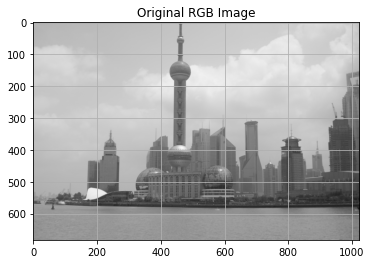

In [ ]:
image3 = read_image('C:\\Users\\wasfy\\Downloads\\CVDS\\shanghai-21.png')

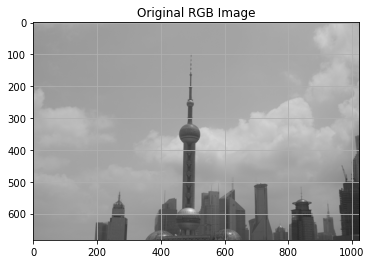

In [ ]:
image4 = read_image('C:\\Users\\wasfy\\Downloads\\CVDS\\shanghai-22.png')

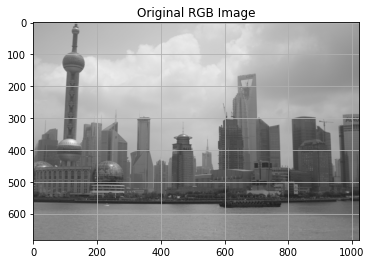

In [ ]:
image5 = read_image('C:\\Users\\wasfy\\Downloads\\CVDS\\shanghai-23.png')

In [ ]:
N=5
(pa3,pa4)=get_correspondance_manually(image3,image4,2*N)
(pb3,pb5)=get_correspondance_manually(image3,image5,2*N)
(Pc4,Pc5)=get_correspondance_manually(image4,image5,2*N)

p1 of index  0  is  (463.9345156567327, 122.16249940962553)
p2 of index  0  is  (490.6505029991031, 320.0658669059652)
p1 of index  1  is  (461.8065224578473, 383.90566287252636)
p2 of index  1  is  (488.52250980021745, 579.6810371699806)
p1 of index  2  is  (244.75121617153917, 339.2178056959335)
p2 of index  2  is  (269.3392103150243, 530.7371935956171)
p1 of index  3  is  (593.7421007887403, 294.5299485193407)
p2 of index  3  is  (622.586081329996, 490.30532281679496)
p1 of index  4  is  (746.9576111084873, 437.1054928446607)
p2 of index  4  is  (780.0575780475137, 632.880867142115)
p1 of index  0  is  (459.6785292589619, 47.682737448637454)
p2 of index  0  is  (131.01965238747493, 20.01882586312763)
p1 of index  1  is  (578.8461483965427, 447.7454588390875)
p2 of index  1  is  (233.16332593397283, 428.5935200491192)
p1 of index  2  is  (1017.2127473669295, 177.49032258064517)
p2 of index  2  is  (669.4019317054745, 188.1302885750721)
p1 of index  3  is  (810.7974070750483, 356.2417

In [ ]:
(pa3,pa4)=get_correspondance_manually(image3,image4,2*N)

p1 of index  0  is  (578.8461483965427, 445.6174656402021)
p2 of index  0  is  (603.4341425400276, 647.7768195343126)
p1 of index  1  is  (459.6785292589619, 379.64967647475567)
p2 of index  1  is  (482.13853020356146, 579.6810371699806)
p1 of index  2  is  (457.55053606007647, 120.03450621074012)
p2 of index  2  is  (494.9064893968739, 315.8098805081944)
p1 of index  3  is  (461.8065224578473, 51.938723846408266)
p2 of index  3  is  (494.9064893968739, 249.84209134274784)
p1 of index  4  is  (374.558801303547, 449.8734520379729)
p2 of index  4  is  (397.0188022481466, 654.1607991309687)


In [ ]:
H3=get_homography_matrix(pa3,pa4)
H4=get_homography_matrix(pb3,pb5)
H5=get_homography_matrix(Pc4,Pc5)
print(H3)
print(H4)
print(H5)


[[ 5.83894417e-01 -9.50438253e-02  1.43719173e+02]
 [-2.51517252e-01  7.52372513e-01  2.81864235e+02]
 [-3.75755661e-04 -1.23069166e-04  1.00000000e+00]]
[[ 1.06713463e+00 -6.61593769e-02 -3.50708134e+02]
 [ 9.36023522e-02  1.01242937e+00 -7.10793083e+01]
 [ 9.26667113e-05 -8.46521382e-05  1.00000000e+00]]
[[ 1.72926655e+00 -7.59669977e-02 -6.49318806e+02]
 [ 3.01997684e-01  1.46211873e+00 -4.81782396e+02]
 [ 7.10191133e-04  7.26302962e-05  1.00000000e+00]]


C:\Users\wasfy\.conda\envs\jupyterlab\lib\site-packages\ipykernel_launcher.py:21: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


In [ ]:
pNewa4=pa3
pNewb5=pa3
pNewc5=pa3
for x in range(N) :
  pNewa4[x] =(verify_H(pa3[x,0],pa3[x,1],H3))[0][:1]
print('++++++++++++++++++++++++++error+++++++++++++++++++++++++')
print(pNewa4-pa4)
for x in range(N) :
  pNewb5[x] =(verify_H(pb3[x,0],pb3[x,1],H4))[0][:1]
print('++++++++++++++++++++++++++error+++++++++++++++++++++++++')
print(pNewa4-pa4)
for x in range(N) :
  pNewc5[x] =(verify_H(Pc4[x,0],Pc5[x,1],H5))[0][:1]
print('++++++++++++++++++++++++++error+++++++++++++++++++++++++')
print(pNewc5-Pc5)

[[347.98852129]
 [517.71775691]
 [  1.        ]]
[[350.69894188]
 [514.03968738]
 [  1.        ]]
[[502.86110463]
 [307.55401684]
 [  1.        ]]
[[365.63881201]
 [493.76612498]
 [  1.        ]]
[[383.68242642]
 [469.28074863]
 [  1.        ]]
++++++++++++++++++++++++++error+++++++++++++++++++++++++
[[-142.66198171   27.92265438]
 [-137.82356792 -228.98209529]
 [ 233.52189432  -27.87608897]
 [-256.94726932 -124.66651081]
 [-396.37515163 -249.19844072]]
[[131.60147013]
 [ 19.47222915]
 [  1.        ]]
[[233.69832738]
 [429.65121618]
 [  1.        ]]
[[669.96617234]
 [188.86550967]
 [  1.        ]]
[[469.82180584]
 [349.75194843]
 [  1.        ]]
[[560.87102489]
 [465.75849792]
 [  1.        ]]
++++++++++++++++++++++++++error+++++++++++++++++++++++++
[[-359.04903287 -188.46439677]
 [-254.82418242 -345.98270979]
 [ 400.62696202  139.22897874]
 [-152.76427549  -20.48351697]
 [-219.18655316  -72.00984225]]
[[ 142.77893376]
 [-143.91870305]
 [   1.        ]]
[[248.33663031]
 [230.50649238]


-39
-86


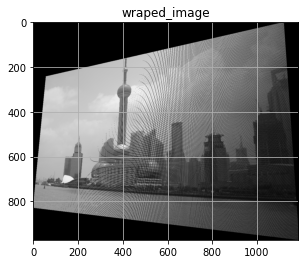

In [ ]:
(wraped_image3,height_shift3,width_shift3) = wrap(image3,H3)
print(height_shift3)
print(width_shift3)
plot_image(BGR2RGB(wraped_image3),'colored','wraped_image')

71
420


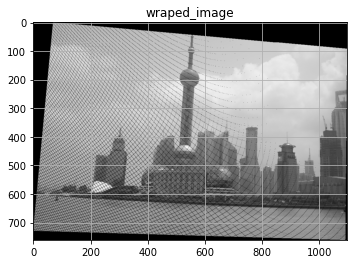

In [ ]:
(wraped_image4,height_shift4,width_shift4) = wrap(image3,H4)
print(height_shift4)
print(width_shift4)
plot_image(BGR2RGB(wraped_image4),'colored','wraped_image')

481
668


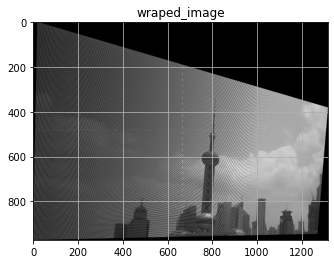

In [ ]:
(wraped_image5,height_shift5,width_shift5) = wrap(image4,H5)
print(height_shift5)
print(width_shift5)
plot_image(BGR2RGB(wraped_image5),'colored','wraped_image')

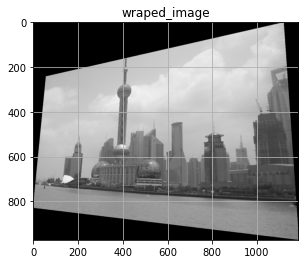

In [ ]:
wraped_image3=remove_holes(wraped_image3,H3,image3,height_shift3,width_shift3)
plot_image(BGR2RGB(wraped_image3),'colored','wraped_image')

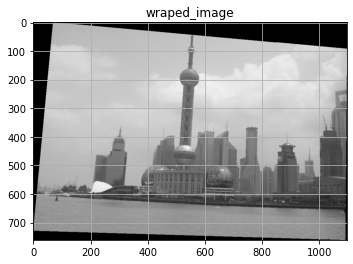

In [ ]:
wraped_image4=remove_holes(wraped_image4,H4,image3,height_shift4,width_shift4)
plot_image(BGR2RGB(wraped_image4),'colored','wraped_image')

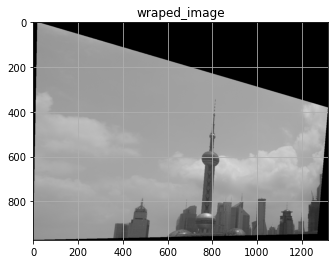

In [ ]:
wraped_image5=remove_holes(wraped_image5,H5,image4,height_shift5,width_shift5)
plot_image(BGR2RGB(wraped_image5),'colored','wraped_image')

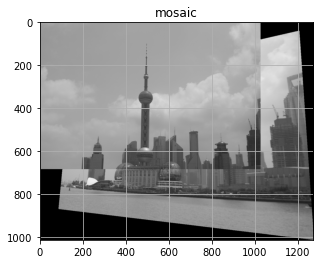

In [ ]:
mosaic3=create_mosaic(image4,wraped_image3,-height_shift3,-width_shift3)
plot_image(BGR2RGB(mosaic3),'colored','mosaic')

<module 'cv2' from 'C:\\Users\\wasfy\\.conda\\envs\\jupyterlab\\lib\\site-packages\\cv2.cp37-win_amd64.pyd'>

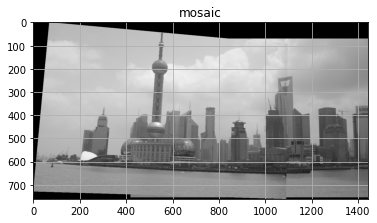

In [ ]:
mosaic4=create_mosaic(wraped_image4,image5,height_shift4,width_shift4)
plot_image(BGR2RGB(mosaic4),'colored','mosaic')
cv

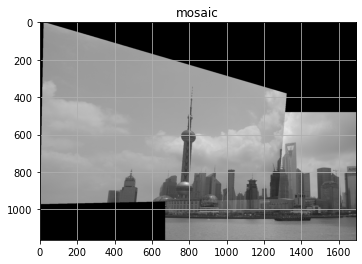

In [ ]:
mosaic5=create_mosaic(wraped_image5,image5,height_shift5,width_shift5)
plot_image(BGR2RGB(mosaic5),'colored','mosaic')

After seeing the output of the 3 possible mixes between 3 images 


ignoring the fact that output should be diffrent if we transform 1 to 2 or 2 to 1 but regardless of that 
we would assume a valid greedy assumbtion,


that assumption is saying that after one image stiching operation the output has more noise than the original ones of course.




so the approach is to join 2 photos that have more information together then the last one with them.so we benifit from most information before it becomes more noisy


The best to start with is image3,image5 then (image3,image5)with image 4 (this photo has low or no more new information than the first two photos)



In [ ]:
cv.imwrite('C:\\Users\\wasfy\\Downloads\\CVDS\\shanghai-intermidate.png',mosaic4)

True

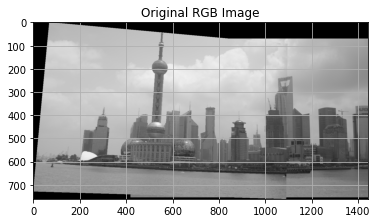

In [ ]:
imageIntermediate = read_image('C:\\Users\\wasfy\\Downloads\\CVDS\\shanghai-intermidate.png')

Greedly we will transform the untransformed image as it has lower noise than the Intermidate Image

In [ ]:
N=5
(pI,pO)=get_correspondance_manually(image4,imageIntermediate,2*N)

p1 of index  0  is  (842.717305058329, 556.2731119822415)
p2 of index  0  is  (887.1511406035993, 422.49887120389167)
p1 of index  1  is  (489.4704340433571, 315.8098805081944)
p2 of index  1  is  (548.0604118452748, 164.4298209984413)
p1 of index  2  is  (493.7264204411279, 241.33011854720644)
p2 of index  2  is  (554.0620176640064, 92.41055117366454)
p1 of index  3  is  (489.4704340433571, 579.6810371699806)
p2 of index  3  is  (536.057200207812, 425.49967411325736)
p1 of index  4  is  (608.638053180938, 641.3928399376564)
p2 of index  4  is  (647.0869078543428, 500.5197468473999)


In [ ]:
HL=get_homography_matrix(pI,pO)
HL

C:\Users\wasfy\.conda\envs\jupyterlab\lib\site-packages\ipykernel_launcher.py:21: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


array([[ 6.63886789e-01, -1.07793729e-01,  1.84313040e+02],
       [-2.91896353e-02,  8.07689703e-01, -9.89244357e+01],
       [-1.84890505e-04, -1.32065744e-04,  1.00000000e+00]])

In [ ]:
N=5
PN=pI
for x in range(N) :
  PN[x] =(verify_H(pI[x,0],pI[x,1],HL))[0][:1]
print('++++++++++++++++++++++++++error+++++++++++++++++++++++++')
print(PN-pO)

[[887.24151605]
 [422.68388793]
 [  1.        ]]
[[547.62273781]
 [163.4771688 ]
 [  1.        ]]
[[554.34950872]
 [ 93.04254061]
 [  1.        ]]
[[536.38561405]
 [426.18692509]
 [  1.        ]]
[[646.81848579]
 [499.96853834]
 [  1.        ]]
++++++++++++++++++++++++++error+++++++++++++++++++++++++
[[ 9.03754455e-02  4.64742645e+02]
 [-4.37674036e-01  3.83192917e+02]
 [ 2.87491056e-01  4.61938958e+02]
 [ 3.28413844e-01  1.10885940e+02]
 [-2.68422067e-01  1.46298739e+02]]


158
-121


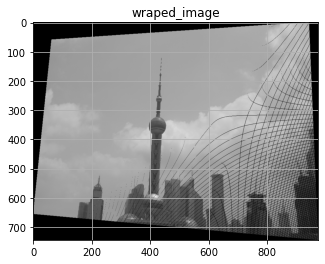

In [ ]:
(wraped_imageL,height_shiftL,width_shiftL) = wrap(image4,HL)
print(height_shiftL)
print(width_shiftL)
plot_image(BGR2RGB(wraped_imageL),'colored','wraped_image')

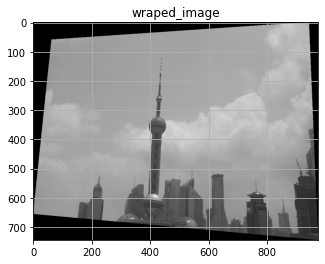

In [ ]:
wraped_imageL=remove_holes(wraped_imageL,HL,image4,height_shiftL,width_shiftL)
plot_image(BGR2RGB(wraped_imageL),'colored','wraped_image')

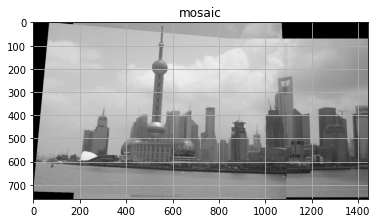

In [ ]:
mosaicL=create_mosaic(imageIntermediate,wraped_imageL,-height_shiftL,-width_shiftL)
plot_image(BGR2RGB(mosaicL),'colored','mosaic')

In [ ]:
cv.imwrite('C:\\Users\\wasfy\\Downloads\\CVDS\\shanghai.png',mosaicL)

True